# Simplistic Analysis of COVID-19 Data

repo: https://github.com/markrichter14/COVID-19/blob/master/COVID-19.ipynb


In [1]:
import datetime as dt
import urllib.request
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#########1#########2#########3#########4#########5#########6#########7#########

In [2]:
def format_num(n):
    if n >= 1e4:
        grp = np.log10(n) // 3
        ltr = {1:'K', 2:'M', 3:'B', 4:'T'}[grp]
        dgt = {0:0, 1:2, 2:1}[np.ceil(np.log10(n)) % 3]
        fmt = '{0:.' + str(dgt) + 'f}'
        return fmt.format(n / (1000 ** grp)) + ltr
    return str(int(n))

tc = [
    (1_234, "1234"), (8_234, "8234"),
    (12_345, "12.3K"), (526_389, "526K"),
    (9_876_543, "9.88M"), (12_345_678, "12.3M"), (526_389_456, "526M"),
    (1_000_000_007, "1.00B"), (25_526_389_456, "25.5B"),
]

for n, sol in sorted(tc):
    res = format_num(n)
    try:
        assert res == sol
    except:
        print(f'Error: {res} does not equal {sol} for {n:,}!')
        raise

In [3]:
info = {
    'Colombia': {'alfa3':'COL'},
    'US': {'alfa3':'USA', 'esp': 'EE.UU.', 
           'loc': 'United States of America'},
    'Spain': {'alfa3':'ESP', 'esp': 'España'},
    'Italy': {'alfa3':'ITA', 'esp': 'Italia'},
    'South Korea': {'alfa3':'KOR', 'esp': 'Corea del Sur', 
                    'loc': 'Republic of Korea'},
    'New Zealand': {'alfa3':'NZL', 'esp': 'Nueva Zelanda'},
    'Ecuador': {'alfa3':'ECU'},
    'Singapore': {'alfa3':'SGP', 'esp': 'Singapur'},
    'China': {'alfa3':'CHN'},
}

In [4]:
def exp_curve(x, a, b, c):
    return a * np.exp(b * x) + c

def log_curve(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

In [5]:
def filter_import(df_import, country):
    '''
    Filters and formats data imported from HDX
    Takes a dataframe containing all data, and a country name as a string
    Return a formatted dataframe
    '''
    SRC = 'HDX'
    
    df = df_import[df_import['Code'] == info[country]['alfa3']]
    df = df[df['Value'] != 0]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.groupby(['Date']).sum()
    df = df.sort_index()
    df = df.rename(columns={"Value": "Cases"})
    df['Day'] = (df.index - df.index[0]).days
    df['New'] = df['Cases'].diff()
    
    df.country = country
    df.source = SRC
    
    return df

---
## Imports from GOV.CO (INS)

Data for Colombia provided by Instituto Nacional de Salud (INS)

https://www.datos.gov.co/en/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data

In [6]:
url = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD'
fn = 'Casos_positivos_de_COVID-19_en_Colombia.csv'

if False:
    urllib.request.urlretrieve(url, fn)

In [7]:
fn = 'Casos_positivos_de_COVID-19_en_Colombia.csv'

df_ins = pd.read_csv(fn, usecols=['Fecha de diagnóstico', 'ID de caso'])

df_ins = df_ins.rename(columns={'Fecha de diagnóstico': 'Date',
                                'ID de caso': 'New'})
df_ins['Date'] = pd.to_datetime(df_ins['Date'], dayfirst=True)
df_ins = df_ins.groupby(['Date']).count()
df_ins = df_ins.sort_index()
idx = pd.date_range(df_ins.index[0], df_ins.index[-1])
df_ins = df_ins.reindex(idx, fill_value=0)
df_ins['Cases'] = df_ins['New'].cumsum()
df_ins['Day'] = (df_ins.index - df_ins.index[0]).days
df_ins.country = 'Colombia'
df_ins.source = 'INS'

print(f'Country: {df_ins.country}, Source: {df_ins.source}')
df_ins.tail()

Country: Colombia, Source: INS


,New,Cases,Day
2020-04-12,67,2776,37
2020-04-13,76,2852,38
2020-04-14,127,2979,39
2020-04-15,126,3105,40
2020-04-16,128,3233,41


---

## Imports from Humanitarian Data Exchage (HDX)

Novel Coronavirus (COVID-19) Cases Data (JHU CSSE)

https://data.humdata.org/dataset/5dff64bc-a671-48da-aa87-2ca40d7abf02


In [8]:
url = 'https://data.humdata.org/hxlproxy/data/download/time_series_covid19_confirmed_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv'
fn = 'time_series_covid19_confirmed_global_narrow.csv'

if False:
    urllib.request.urlretrieve(url, fn)

In [9]:
fn = 'time_series_covid19_confirmed_global_narrow.csv'

df_csv = pd.read_csv(fn, 
                     usecols=['Date',
                              'Value', 
                              'ISO 3166-1 Alpha 3-Codes', 
                              'Country/Region'],
                     skiprows=[1])

df_csv = df_csv.rename(columns={'ISO 3166-1 Alpha 3-Codes': 'Code',
                                'Country/Region': 'Country'})

In [10]:
for country in info:
    info[country]['df'] = filter_import(df_csv, country)

df = info['US']['df']

print(f'Country: {df.country}, Source: {df.source}')
df.tail(7)

Country: US, Source: HDX


,Cases,Day,New
Date,,,
2020-04-10,496535,79,35098.0
2020-04-11,526396,80,29861.0
2020-04-12,555313,81,28917.0
2020-04-13,580619,82,25306.0
2020-04-14,607670,83,27051.0
2020-04-15,636350,84,28680.0
2020-04-16,667801,85,31451.0


---

## UN Population Data

https://population.un.org/wpp/Download/Standard/CSV/

In [11]:
fn = 'WPP2019_TotalPopulationBySex.csv'

df_pop = pd.read_csv(fn, 
                     usecols=[
                         'Location',
                         'Variant',
                         'Time',
                         'PopTotal',
                         'PopDensity',
                     ],
                     skiprows=[1])

for co in info:
    loc = info[co].get('loc', co)
    fltr = ((df_pop.Time == 2019) 
            & (df_pop.Variant == 'Medium') 
            & (df_pop.Location == loc)) 
    df = df_pop[fltr][['Location', 'PopTotal', 'PopDensity']]
    info[co]['PopTotal'] = int(df['PopTotal'].values[0] * 1000)
    info[co]['PopDensity'] = df['PopDensity'].values[0]

In [32]:
data = [[co, info[co]['PopTotal'], info[co]['PopDensity']] for co in info]
df = pd.DataFrame(data, columns=['Country', 'PopTotal', 'PopDensity'])
df

,Country,PopTotal,PopDensity
0,Colombia,50339443,45.371
1,US,329064917,35.974
2,Spain,46736782,93.698
3,Italy,60550092,205.855
4,South Korea,51225321,526.847
5,New Zealand,4783062,18.165
6,Ecuador,17373657,69.954
7,Singapore,5804343,8291.919
8,China,1433783691,152.722


---

## Plotting and analysis


In [13]:
def plot_projected(data, forecast=7, curve=exp_curve, cos=info):
    '''
    Plot cases and growth vs Date
    '''
    if isinstance(data, str):
        df = cos[data]['df']
        country = cos[data].get('esp', data)
        source = cos[data]['df'].source
    else:
        df = data
        country = cos[data.country].get('esp', data.country)
        source = data.source
    
    MIN_CASES = 50
    PERIOD = 5

    df = df[df['Cases'] >= MIN_CASES]
    
    fig, ax = plt.subplots(figsize=(15, 10))

    # original data
    ax.plot(df.index, df['Cases'], 'ks', label="Total de casos")
    ax.set_ylabel('Casos', fontsize=16)

    if forecast:
        if curve == exp_curve:
            popt, pcov = curve_fit(curve, df['Day'], df['Cases'], 
                                   p0=(1, 1e-6, 1))
            curve_name = ' (exponencial)'
        elif curve == log_curve:
            popt, pcov = curve_fit(curve, df['Day'], df['Cases'], 
                                   p0=(1, 1e-6, 1, 30))
            curve_name = ' (logístico)'
        else:
            popt, pcov = curve_fit(curve, df['Day'], df['Cases'])
            curve_name = ''

        # trendline
        ax.plot(df.index, curve(df['Day'], *popt), 'r-', 
                label="Curva ajustada")

        # forecast
        fc_x = np.linspace(df['Day'][-1], 
                           df['Day'][-1] + forecast, 
                           forecast + 1)
        fc_dates = pd.date_range(df.index[-1], 
                                 df.index[-1] 
                                 + pd.to_timedelta(forecast, unit='d'))
        ax.plot(fc_dates, curve(fc_x, *popt), 'b*-', label="Pronóstico")

    ax.legend()
    
    # Growth
    ax2 = ax.twinx()
    new_period = df['Cases'].diff(PERIOD)
    growth = new_period.pct_change() + 1
    growth_avg = growth.rolling(PERIOD, min_periods=PERIOD).mean()

    ax2.plot(growth.index, growth, 'g^-', lw=0.2)
    ax2.plot(growth_avg.index, growth_avg, 'g--', lw=3)

    ax2.set_ylabel('Tasa de Crecimiento', fontsize=16, c='g')
    ax2.tick_params(axis='y', colors='g')
    # '1.0' growth line
    ax2.axhline(y=1.0, ls=':', c='g')
    
    ax.set_xlabel('Fecha', fontsize=16)
    title_str = f'Casos de Coronavirus'

    title_str += f' en {country} (fuente: {source})'
    if forecast:
        title_str += f'\nproyectados {forecast} dias' + curve_name

    ax.set_title(title_str, fontsize=20)
    ax.grid()

    fig.autofmt_xdate()
    # ax.yaxis.set_minor_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(7))

    # last growth data labels
    last_val = growth_avg[-1]
    ax2.annotate(
        f'{last_val:0.2f}', xy=(df.index[-1], last_val), ha='left', 
        va='bottom', xytext=(5, 1), textcoords="offset points", c='g',
    )

    # last actual data labels
    last_val = df['Cases'][-1]
    ax.annotate(
        format_num(last_val), xy=(df.index[-1], last_val), ha='left', va='top', 
        xytext=(0, 0), textcoords="offset points", rotation=-30, c='k',
    )

    # projection labels
    if forecast:
        for i, yi in enumerate(curve(fc_x[1:], *popt)):
            xi = fc_dates[1:][i]
            ax.annotate(
                format_num(yi), xy=(xi, yi), ha='left', va='top', 
                xytext=(0, 0), textcoords="offset points", rotation=-30, 
                c='b',
            )

    plt.show()

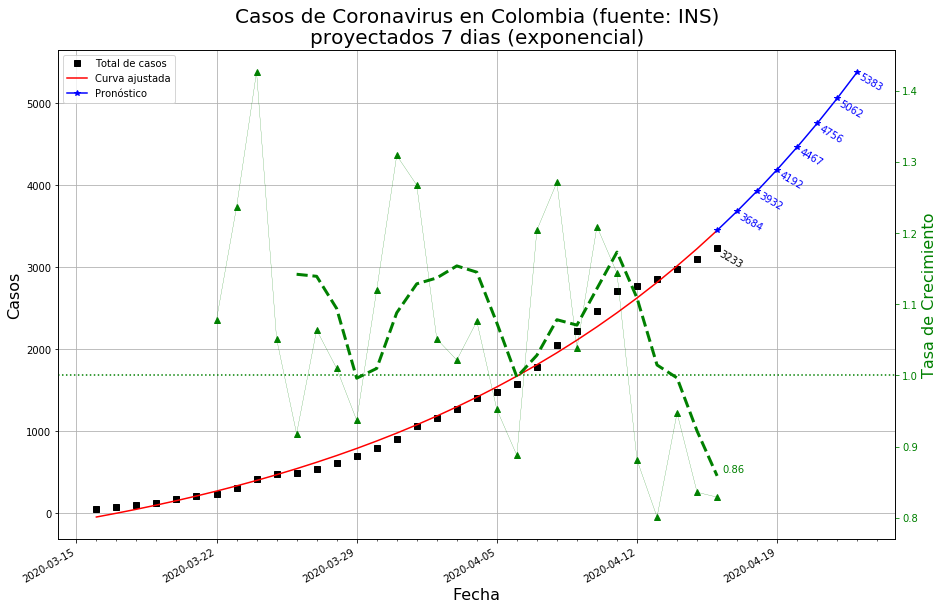

In [14]:
plot_projected(df_ins)

__Mi humilde interpretación:__ Colombia sigue mostrando un crecimiento exponencial de nuevos casos.  La tasa de crecimiento sigue siendo alta y no muestra el declive constante de otros países.

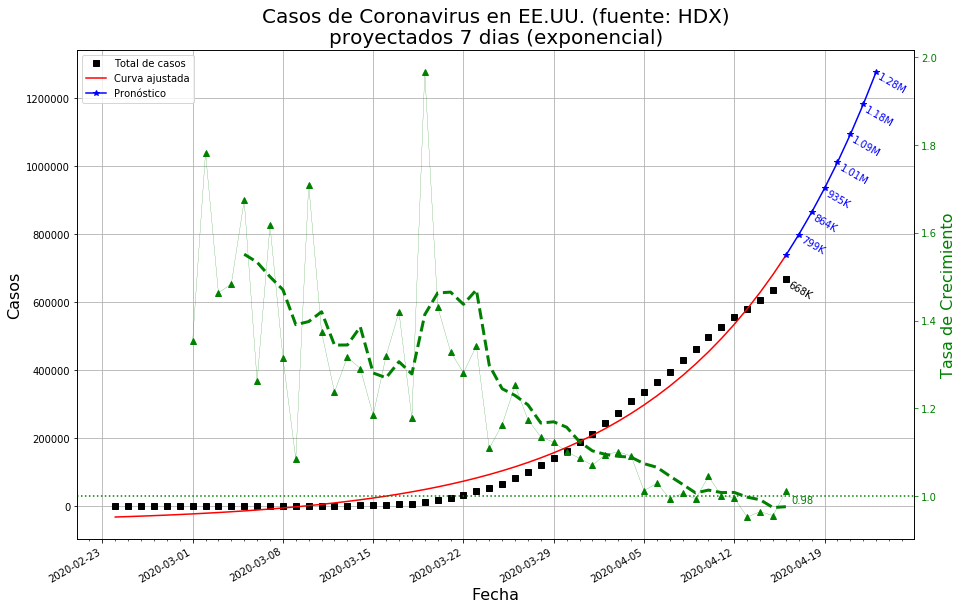

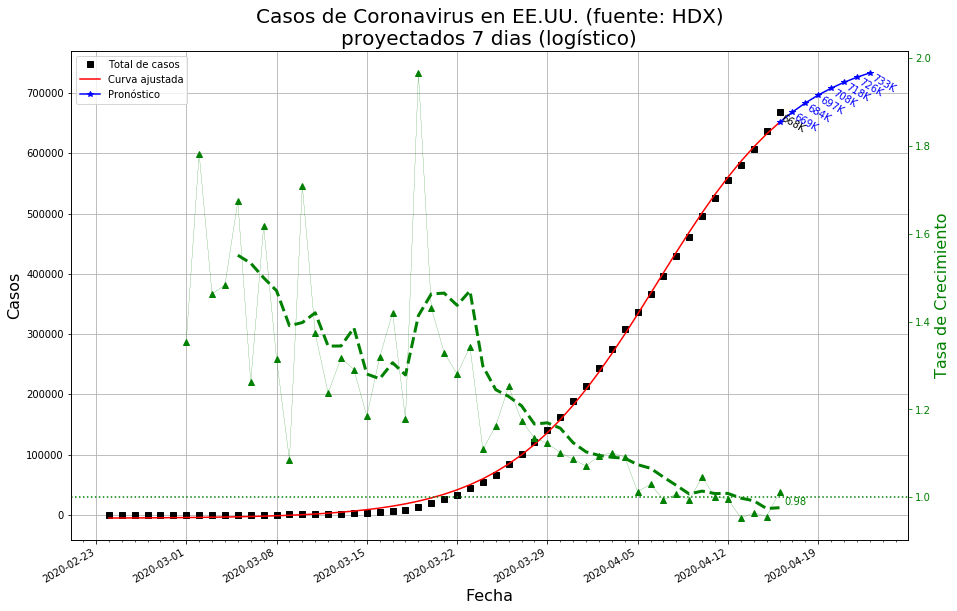

In [15]:
plot_projected('US')

plot_projected('US', curve=log_curve)

__Mi humilde interpretación:__ Los Estados Unidos siguen teniendo un alto número de nuevos casos y han sido noticia por establecer el récord de muertes, pero la tasa de crecimiento ha disminuido a 1,0, lo que indica un posible punto de infección y el fin del crecimiento exponencial de los casos.  Los datos están empezando a alejarse de la curva exponencial y se acercan más a la "S" de la curva logística.

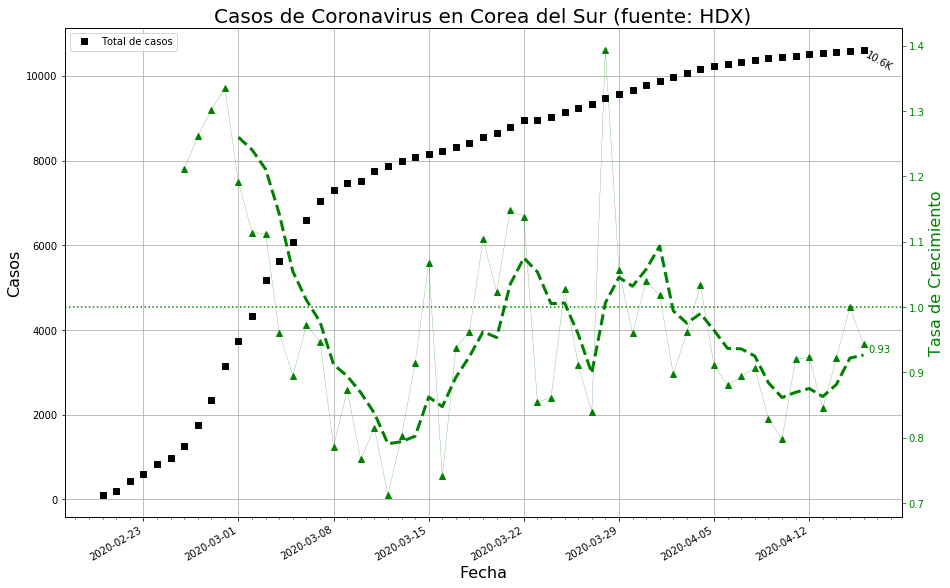

In [16]:
plot_projected('South Korea', 0)

__Mi humilde interpretación:__ Es probable que esta variación de la curva logística en forma de "S" sea típica de los países que han controlado la tasa de nuevas infecciones.  La fase inicial será de naturaleza exponencial, pero la parte superior de la curva se aplanará a partir de la acumulación de casos de adición con una tasa lineal. 

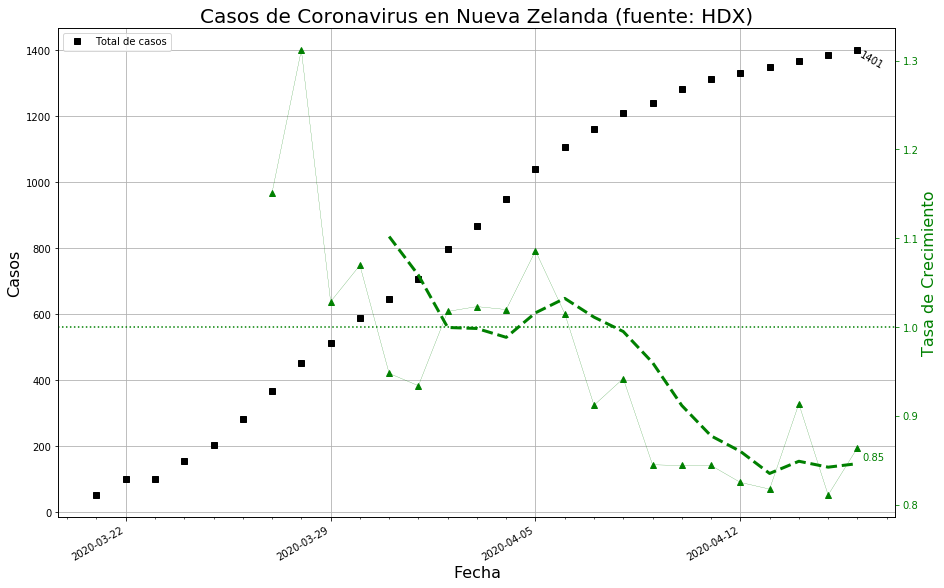

In [17]:
plot_projected('New Zealand', 0)

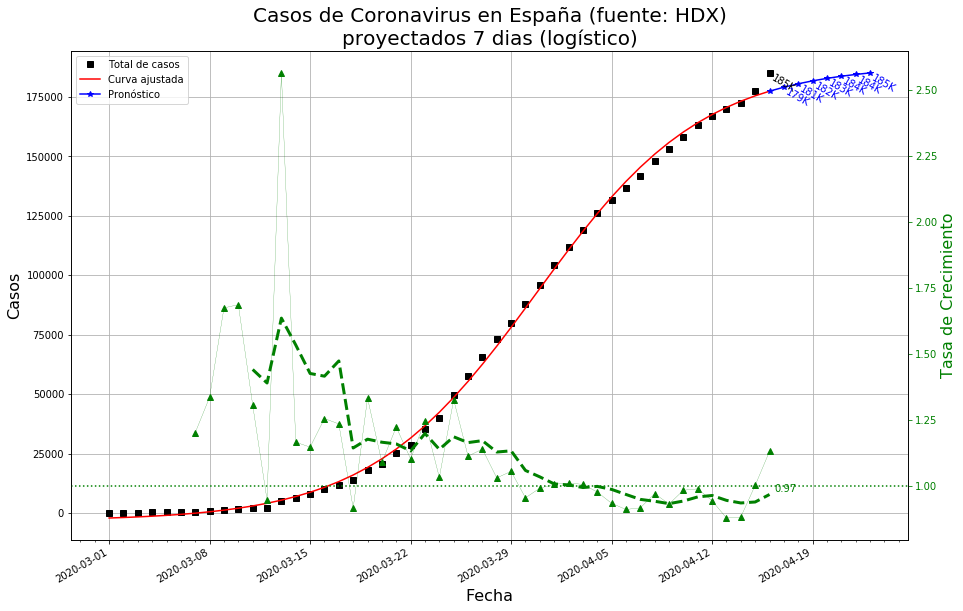

In [18]:
plot_projected('Spain', curve=log_curve)

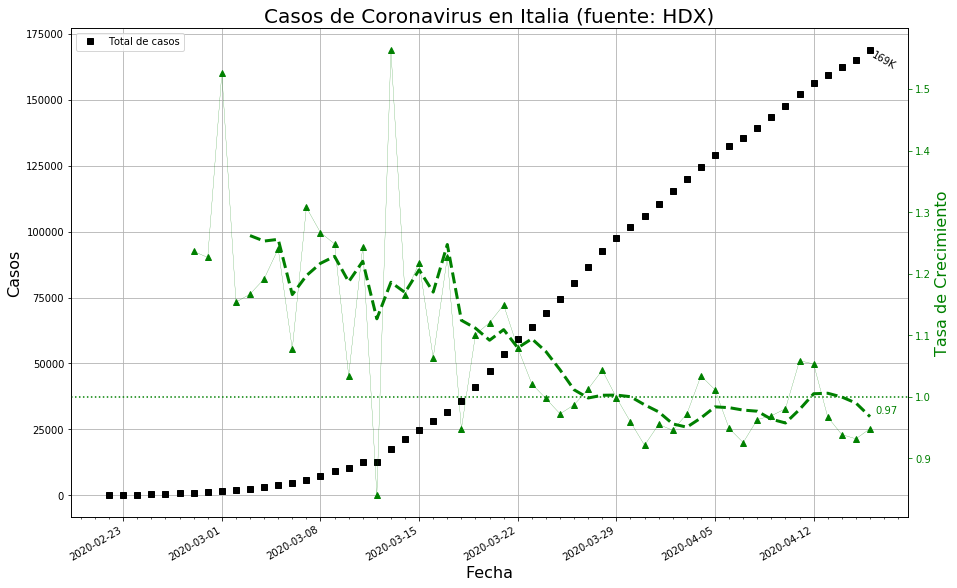

In [19]:
plot_projected('Italy', 0)

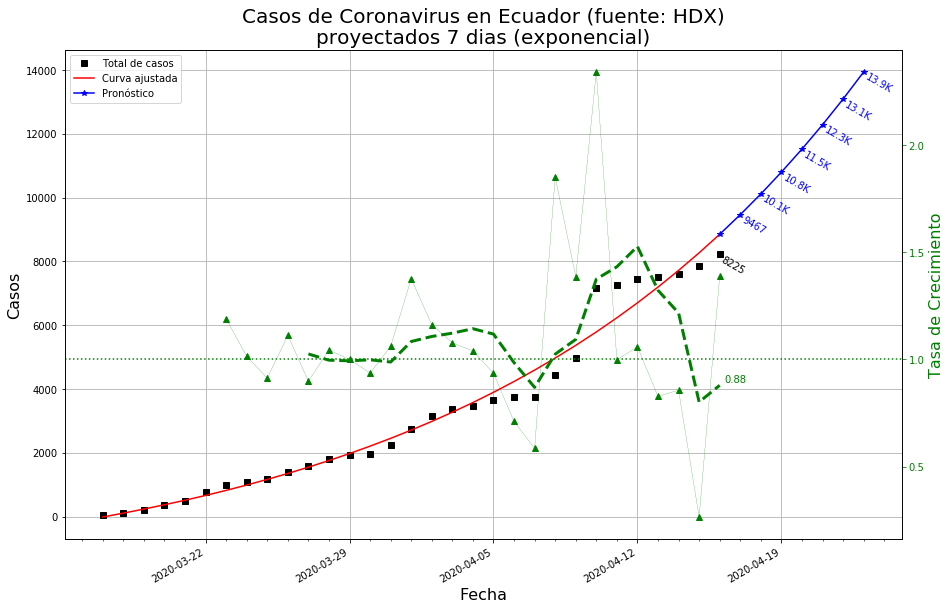

In [20]:
plot_projected('Ecuador')

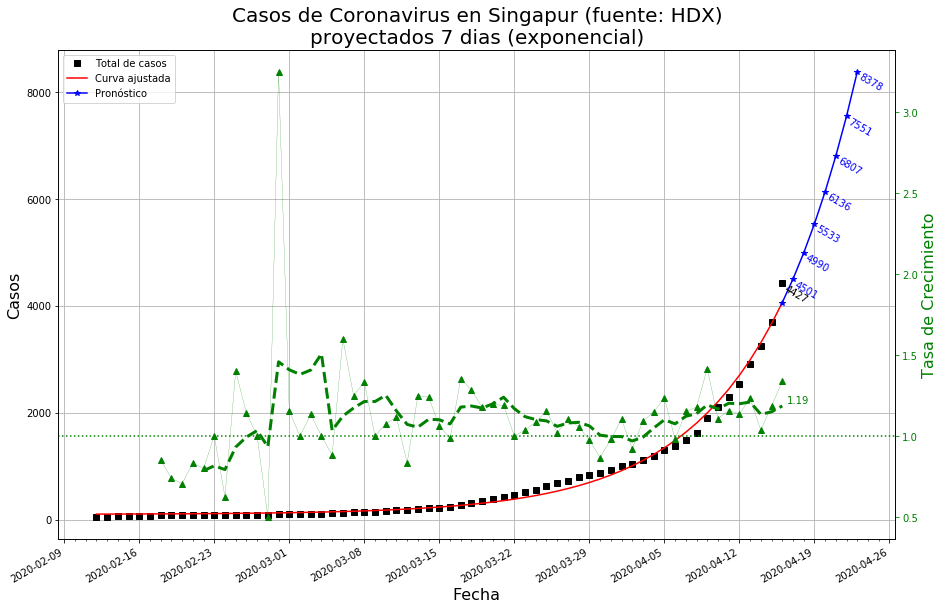

In [21]:
plot_projected('Singapore')

In [22]:
def plot_log_log(dfs, cos=info):
    '''
    Plot New Cases vs Total Cases
    '''
    MIN_CASES = 100
    
    fig, ax = plt.subplots(figsize=(15, 8))

    # original data
    for data in dfs:
        if isinstance(data, str):
            df = cos[data]['df']
            country = cos[data].get('esp', data)
        else:
            df = data
            country = cos[data.country].get('esp', data.country)
        df_min = df[df['Cases'] >= MIN_CASES]
        ax.loglog(df_min['Cases'], df_min['New'].rolling(7).sum(), '.-', 
                  label=country)
    ax.set_ylabel('Nuevos casos en los siete días anteriores\n(Logarítmico)',
                  fontsize=16)

    ax.legend(fontsize=14)

    ax.set_xlabel('Total de casos (logarítmico)', fontsize=16)
    ax.set_title(f'Trayectoria de los casos',
                 fontsize=24)
    ax.grid()

    plt.show()

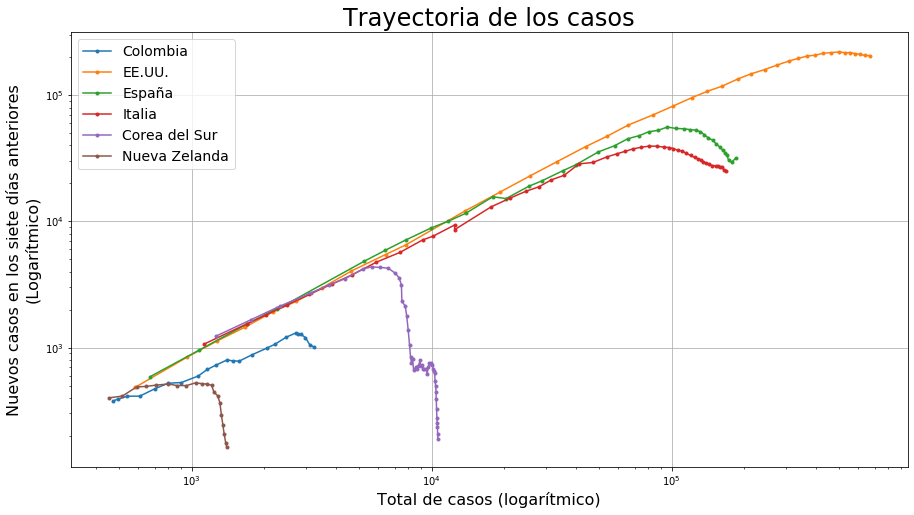

In [23]:
plot_log_log(['Colombia', 'US', 'Spain', 'Italy', 'South Korea', 'New Zealand'])

__Mi humilde interpretación:__  Trazar el número de casos nuevos frente al total de casos de forma logarítmica permite ver el crecimiento exponencial como un movimiento hacia arriba y hacia la derecha.  Los países que controlan las nuevas infecciones muestran una tendencia más descendente.  

En este caso, la tendencia de Corea del Sur y, más recientemente, de Nueva Zelanda, se está moviendo más directamente hacia abajo con muy pocos casos nuevos.  España e Italia están claramente haciendo la transición a menos casos nuevos y es posible que EE.UU. haga lo mismo.  Colombia ha mostrado algunas pausas en la tasa de crecimiento, pero actualmente se encuentra en un crecimiento exponencial.
 
Los nuevos casos se suman en los últimos siete días para suavizar las variaciones diarias de los datos.

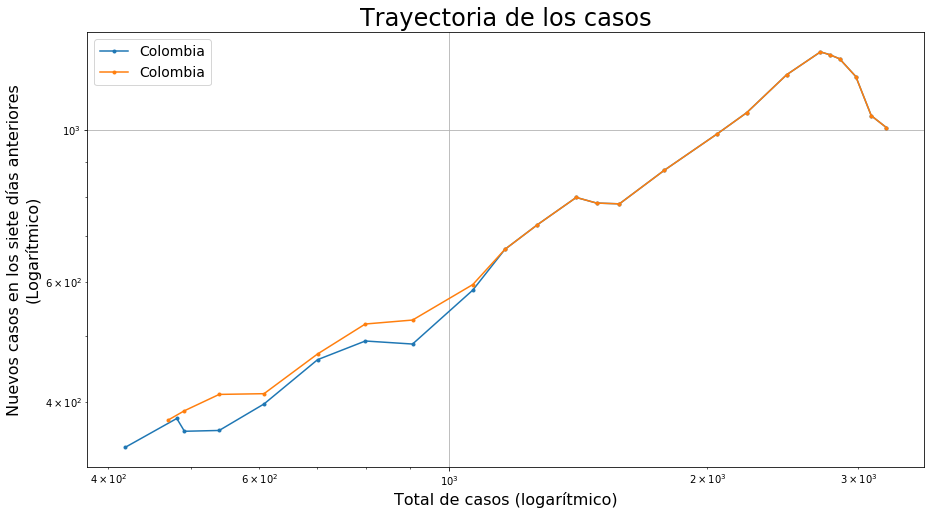

In [24]:
plot_log_log([df_ins, 'Colombia'])

__Explaination:__ Data for Colombia provided by Instituto Nacional de Salud (INS) differs slightly from the data available in the JHU&nbsp;CSSE dataset from Humanitarian Data Exchage (HDX).

In [25]:
def plot_percentage(names, cos=info):
    '''
    Plot cases and growth vs Date
    '''
    MIN_CASES = 100

    fig, ax = plt.subplots(figsize=(15, 10))
    vals = []
    
    for i, name in enumerate(names):
        df = cos[name]['df']
        percentage = df['Cases'] / cos[name]['PopTotal']
        percentage = percentage[df['Cases'] >= MIN_CASES]
        country = cos[name].get('esp', data)

        # original data
        label = cos[name].get('esp', name)
        ax.plot(percentage.index, percentage, 'o-', label=label, lw=2)
        vals.append((percentage[-1], i))
    
    order =[j for i, j in sorted(vals, reverse=True)]
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax.legend(handles, labels, fontsize=16)
    
    ax.set_ylabel('Porcentaje', fontsize=16)
    ax.set_yticklabels([f'{x:,.2%}' for x in ax.get_yticks()])
    
    ax.set_xlabel('Fecha', fontsize=16)
    title_str = f'Casos de COVID-19 como porcentaje de la población'

    ax.set_title(title_str, fontsize=20)
    ax.grid()

    fig.autofmt_xdate()
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(7))

    plt.show()

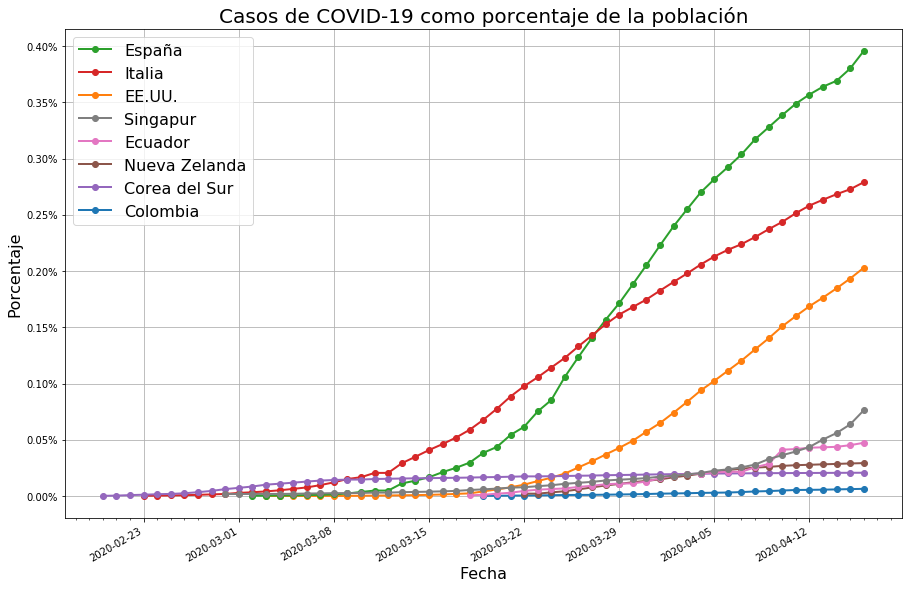

In [26]:
plot_percentage(['Colombia', 'US', 'Spain', 'Italy',
                 'South Korea', 'New Zealand', 'Ecuador', 'Singapore'])

In [27]:
def compare_dfs(data_A, data_B, num_days=None, cos=info):
    '''
    Compare Cases from two countries
    '''
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax2 = ax1.twinx()

    dfs = [data_A, data_B]
    names = ['', '']
    
    for i, data in enumerate(dfs):
        if isinstance(data, str):
            names[i] = cos[data].get('esp', data)
            dfs[i] = cos[data]['df']
        else:
            names[i] = cos[data.country].get('esp', data.country)
    
    df_A, df_B = dfs
    co_A, co_B = names

    # limit US data to same number as Colombia
    pts = min(len(df_A), len(df_B))
    if num_days and pts - num_days > 0:
        df_A = df_A[-pts:num_days - pts]
        df_B = df_B[-pts:num_days - pts]
    else:
        df_A = df_A[-pts:]
        df_B = df_B[-pts:]

    popt_A, pcov_A = curve_fit(exp_curve, df_A['Day'], df_A['Cases'],
                               p0=(1, 1e-6, 1))
    popt_B, pcov_B = curve_fit(exp_curve, df_B['Day'], df_B['Cases'], 
                               p0=(1, 1e-6, 1))

    # original data
    ax1.plot(df_A.index, df_A['Cases'], 'r^', label=f'Casos, {co_A}')
    ax1.set_ylabel(f'Casos, {co_A}', c='r', fontsize=16)
    ax1.tick_params(axis='y', colors='r')

    ax2.plot(df_B.index, df_B['Cases'], 'bv', label=f'Casos, {co_B}')
    ax2.set_ylabel(f'Casos, {co_B}', c='b', fontsize=16)
    ax2.tick_params(axis='y', colors='b')

    # trendline
    ax1.plot(df_A.index, exp_curve(df_A['Day'], *popt_A), 'r-', 
             label=f"Curva ajustada, {co_A}")
    ax2.plot(df_B.index, exp_curve(df_B['Day'], *popt_B), 'b-', 
            label=f"Curva ajustada,  {co_B}")

    # Match limits for y axes
    max_A = df_A['Cases'].max()
    max_B = df_B['Cases'].max()
    ax1.set_ylim([max_A * -0.1, max_A * 1.1])
    ax2.set_ylim([max_B * -0.1, max_B * 1.1])

    # Legend (Combined, Reordered)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2)

    ax1.set_xlabel('Fecha', fontsize=16)
    date_fmt = '%-d/%-m/%y'
    dates = [df_A.index[0].strftime(date_fmt), 
             df_A.index[-1].strftime(date_fmt)]
    ax1.set_title(f'Comparación del número de casos de COVID-19\n' 
                  + f'{co_A} y {co_B}, de {dates[0]} a {dates[1]}',
                  fontsize=20)
    ax1.grid()

    fig.autofmt_xdate()
    # ax.yaxis.set_minor_locator(MultipleLocator(100))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.xaxis.set_major_locator(MultipleLocator(7))

    plt.show()

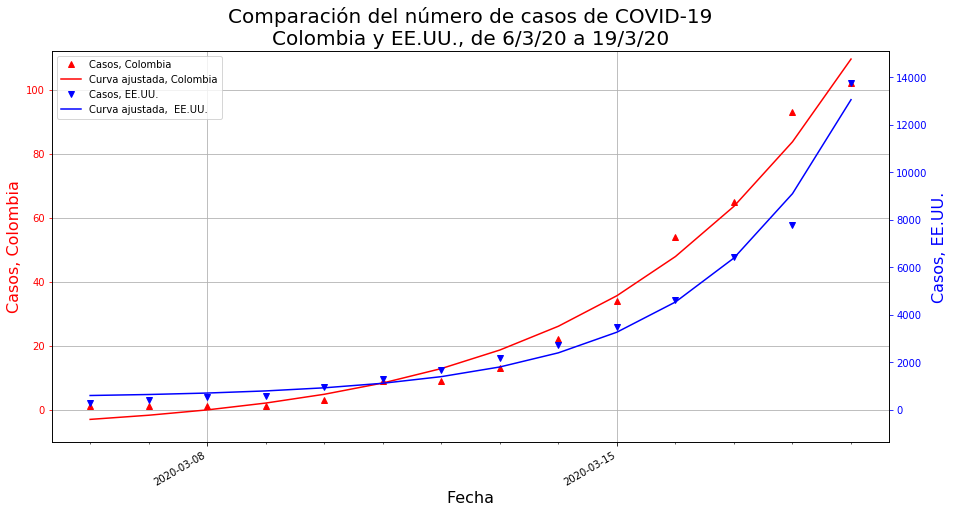

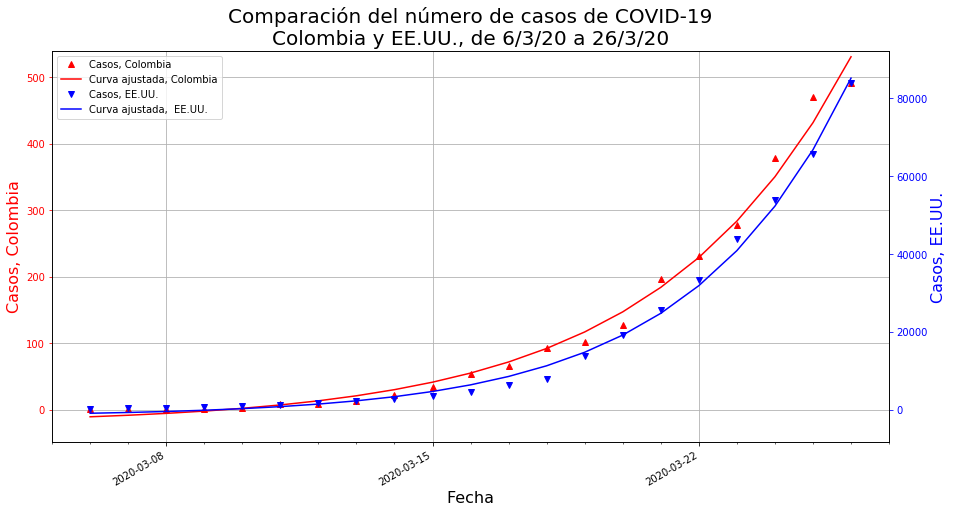

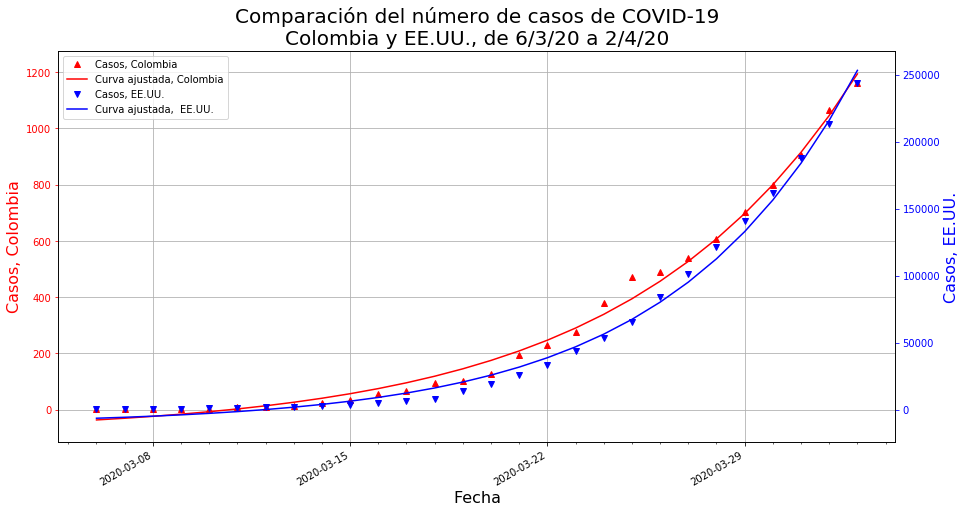

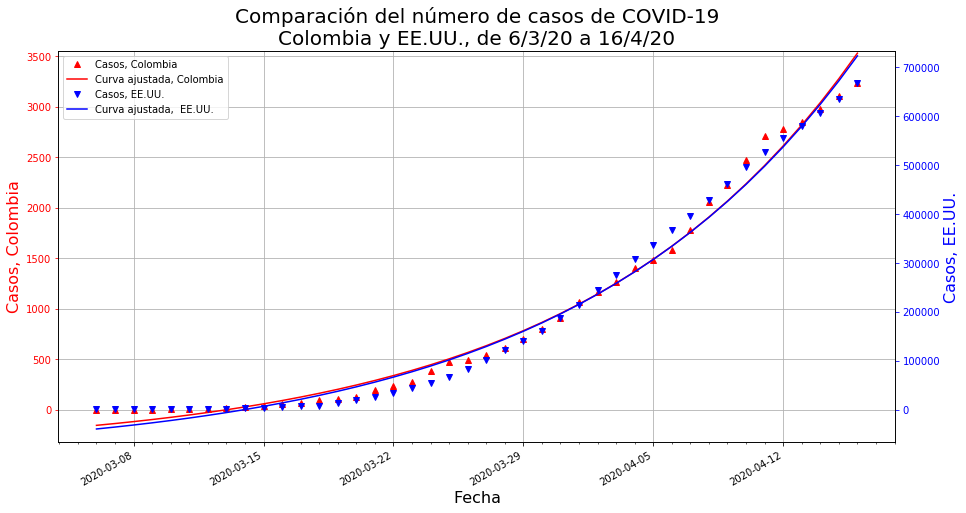

In [28]:
for days in [14, 21, 28]:
    compare_dfs('Colombia', 'US', days)

compare_dfs('Colombia', 'US')

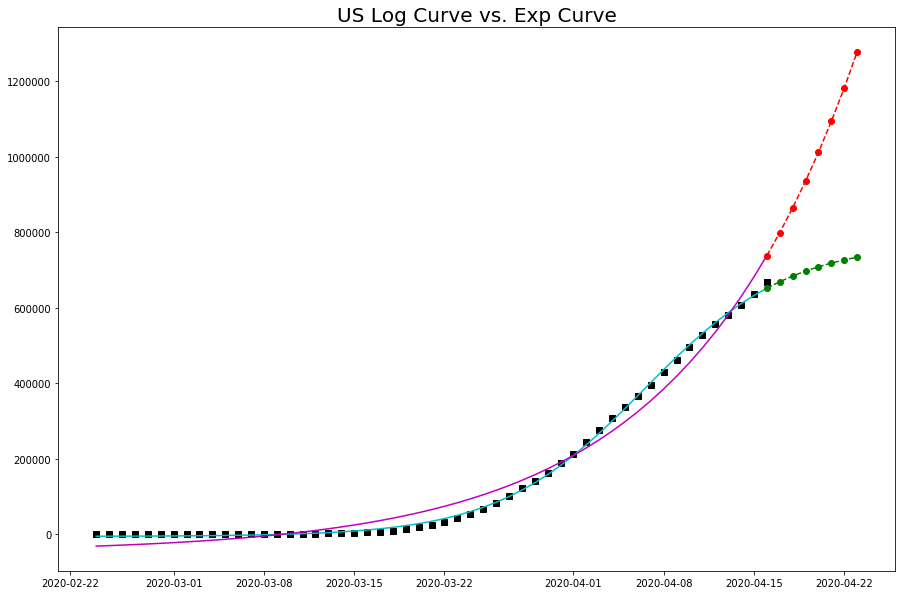

In [34]:
#########1#########2#########3#########4#########5#########6#########7#########
'''
Experiment with fitting and comparing logistic curve and exponential curve
'''
MIN_CASES = 50
df = info['US']['df']
df = df[df['Cases'] >= MIN_CASES]

popt, pcov = curve_fit(log_curve, df['Day'], df['Cases'], p0=(1, 1e-6, 1, 30))
forecast = 7
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(df.index, df['Cases'], 'ks', label="Total de casos")
ax.plot(df.index, log_curve(df['Day'], *popt), 'c-', label="Curva ajustada")
fc_x = np.linspace(df['Day'][-1], 
                   df['Day'][-1] + forecast,
                   forecast + 1)
fc_dates = pd.date_range(df.index[-1], 
                         df.index[-1] + pd.to_timedelta(forecast, unit='d'))
ax.plot(fc_dates, log_curve(fc_x, *popt), 'go--', label="Pronóstico")

popt, pcov = curve_fit(exp_curve, df['Day'], df['Cases'], p0=(1, 1e-6, 1))
ax.plot(df.index, exp_curve(df['Day'], *popt), 'm-', label="Curva ajustada")
fc_x = np.linspace(df['Day'][-1], 
                   df['Day'][-1] + forecast,
                   forecast + 1)
fc_dates = pd.date_range(df.index[-1], 
                         df.index[-1] + pd.to_timedelta(forecast, unit='d'))
ax.plot(fc_dates, exp_curve(fc_x, *popt), 'ro--', label="Pronóstico")

ax.set_title('US Log Curve vs. Exp Curve', fontsize=20)

plt.show()

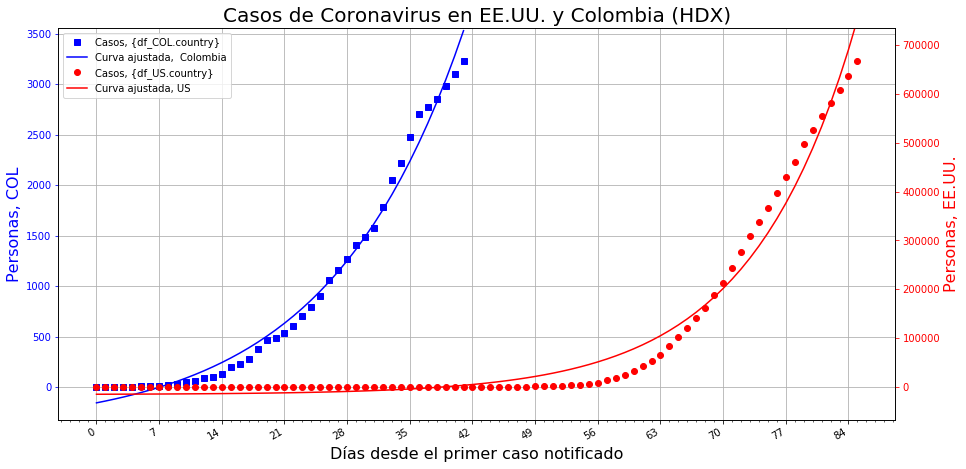

In [35]:
#########1#########2#########3#########4#########5#########6#########7#########
'''
Plot Cases vs Number of Days
'''
fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()

df_US  = info['US']['df']
df_COL  = info['Colombia']['df']

popt_US, pcov_US = curve_fit(exp_curve, df_US['Day'], 
                             df_US['Cases'], p0=(1, 1e-6, 1))
popt_COL, pcov_COL = curve_fit(exp_curve, df_COL['Day'], 
                               df_COL['Cases'], p0=(1, 1e-6, 1))

# trendline
ax2.plot(df_US['Day'], exp_curve(df_US['Day'], *popt_US), 'r-', 
         label=f"Curva ajustada, {df_US.country}")
ax.plot(df_COL['Day'], exp_curve(df_COL['Day'], *popt_COL), 'b-', 
        label=f"Curva ajustada,  {df_COL.country}")

# original data
ax2.plot(df_US['Day'], df_US['Cases'], 'ro', label="Casos, {df_US.country}")
ax2.set_ylabel('Personas, EE.UU.', c='r', fontsize=16)
ax2.tick_params(axis='y', colors='r')

ax.plot(df_COL['Day'], df_COL['Cases'], 'bs', 
        label="Casos, {df_COL.country}")
ax.set_ylabel('Personas, COL', c='b', fontsize=16)
ax.tick_params(axis='y', colors='b')

# Hack limits for y axes
max_US = df_US['Cases'].max()
max_COL = df_COL['Cases'].max()
ax.set_ylim([max_COL * -0.1, max_COL * 1.1])
ax2.set_ylim([max_US * -0.1, max_US * 1.1])

# Legend (Combined, Reordered)
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(reversed(handles2 + handles), reversed(labels2 + labels))

ax.set_xlabel('Días desde el primer caso notificado', fontsize=16)
title_str = 'Casos de Coronavirus en EE.UU. y Colombia (HDX)'
ax.set_title(title_str, fontsize=20)
ax.grid()

fig.autofmt_xdate()
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(7))

plt.show()